# 1D AMRVAC snapshot

We create a Magritte model form a snapshot of 1D AMRVAC hydrodynamics simulation.
Currently, the AMRVAC binary files can not yet be used directly to extract the snapshot data.
Currently we use the corresponding `.vtu` files.  

## Setup

Import the required functionalty.

In [1]:
import magritte.setup as setup                    # Model setup
import magritte.core  as magritte                 # Core functionality
# import magritte.core  as magritte                 # Core functionality
import vtk                                        # Reading the model
import numpy as np                                # Data structures
import matplotlib.pyplot as plt                   # Plotting

from tqdm                   import tqdm           # Progress bars
from astropy                import constants      # Unit conversions
from vtk.util.numpy_support import vtk_to_numpy   # Converting data

Define a working directory (you will have to change this).

In [2]:
wdir = "/home/frederik/Magritte-examples/AMRVAC_1D/"

Create the working directory.

In [3]:
!mkdir -p $wdir

Define file names.

In [4]:
input_file = f'{wdir}model_AMRVAC_1D.vtu'    # AMRVAC snapshot
model_file = f'{wdir}model_AMRVAC_1D.hdf5'   # Resulting Magritte model
lamda_file = f'{wdir}co.txt'                 # Line data file

We use a snapshot and data file that can be downloaded with the following links.

In [5]:
input_link = "https://owncloud.ster.kuleuven.be/index.php/s/NpPG88x5LCbaZNC/download"
lamda_link = "https://home.strw.leidenuniv.nl/~moldata/datafiles/co.dat"

Dowload the snapshot and the linedata (``%%capture`` is just used to suppress the output).

In [6]:
%%capture
!wget $input_link --output-document $input_file
!wget $lamda_link --output-document $lamda_file

## Extract data 

The script below extract the required data from the snapshot `.vtu` file.

In [7]:
# Create a vtk reader to read the AMRVAC file and extract its contents.
reader = vtk.vtkXMLUnstructuredGridReader()
reader.SetFileName(input_file)
reader.Update()

# Extract the grid output
grid = reader.GetOutput()

# Extract the number of cells
ncells = grid.GetNumberOfCells() 

# Extract cell data
cellData = grid.GetCellData()
for i in tqdm(range(cellData.GetNumberOfArrays())):
    array = cellData.GetArray(i)
    if (array.GetName() == 'rho'):
        rho = vtk_to_numpy(array)
    if (array.GetName() == 'temperature'):
        tmp = vtk_to_numpy(array)
    if (array.GetName() == 'v1'):
        v_x = vtk_to_numpy(array)

# Convert rho (total density) to abundances
nH2 = rho * 1.0e+6 * constants.N_A.si.value / 2.02
nCO = nH2 * 1.0e-4

# Convenience arrays
zeros = np.zeros(ncells)
ones  = np.ones (ncells)

# Since it is a 1D model there is no y or z data.
v_y = v_z = zeros

# Convert to fractions of the speed of light
velocity = np.array((v_x, v_y, v_z)).transpose() / constants.c.cgs.value

# Define turbulence at 150 m/s
trb = (150.0/constants.c.si.value)**2 * ones

# Extract cell centres to use as positions of the Magritte points.
centres = []
for c in tqdm(range(ncells)):
    cell = grid.GetCell(c)
    centre = np.zeros(3)
    for i in range(2):
        centre = centre + np.array(cell.GetPoints().GetPoint(i))
    centre = 0.5 * centre
    centres.append(centre)
centres  = np.array(centres)
centres *= 1.0e-2   # convert [cm] to [m]

# Define AMRVAC cell centres as Magritte point positions
position = centres

100%|██████████| 2000/2000 [00:00<00:00, 76201.19it/s]


## Create model

Now all data is read we can use it to construct a Magritte model.

In [8]:
model = magritte.Model ()                              # Create model object

model.parameters.set_model_name         (model_file)   # Magritte model file
model.parameters.set_spherical_symmetry (True)         # Assume spherical symmetry
model.parameters.set_dimension          (1)            # Spherical symmetry is 1D
model.parameters.set_npoints            (ncells)       # Number of points
model.parameters.set_nrays              (50)           # Number of rays  
model.parameters.set_nspecs             (5)            # Number of species (min. 5)
model.parameters.set_nlspecs            (1)            # Number of line species
model.parameters.set_nquads             (21)           # Number of quadrature points
model.parameters.set_pop_prec           (1.0e-6)       # Pops. convergence criterion

model.geometry.points.position.set (position)
model.geometry.points.velocity.set (velocity)

model.chemistry.species.abundance = np.array((zeros, nCO, nH2, zeros, ones)).T
model.chemistry.species.symbol    = ['dummy0', 'test', 'H2', 'e-', 'dummy1']

model.thermodynamics.temperature.gas  .set(tmp)
model.thermodynamics.turbulence.vturb2.set(trb)

model = setup.set_Delaunay_neighbor_lists  (model)
model = setup.set_Delaunay_boundary        (model)
model = setup.set_boundary_condition_CMB   (model)
model = setup.set_uniform_rays             (model)
model = setup.set_linedata_from_LAMDA_file (model, lamda_file)
model = setup.set_quadrature               (model)

model.write()

## Plot model

The data can be extracted from the Magritte model by casting it into numpy arrays.

In [20]:
position  = np.array(model.geometry.points.position)
velocity  = np.array(model.geometry.points.velocity)
abundance = np.array(model.chemistry.species.abundance)

rs  = np.linalg.norm(position, axis=1)
vs  = np.linalg.norm(velocity, axis=1)
nCO = abundance[:,1]

Plot of the CO number density.

Text(0, 0.5, 'CO number density [m$^{-3}$]')

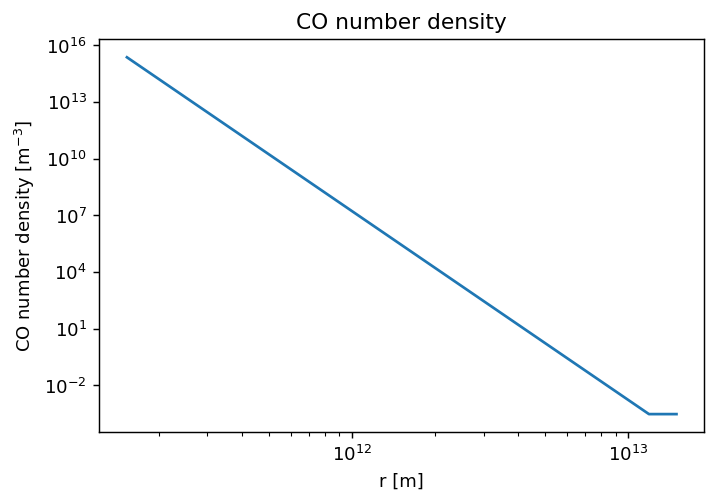

In [26]:
plt.figure(dpi=130)
plt.title('CO number density')
plt.plot(rs, nCO)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'r [m]')
plt.ylabel(r'CO number density [m$^{-3}$]')

Plot of the lengths of the velocity vectors.

Text(0, 0.5, '|velocity| [m/s]')

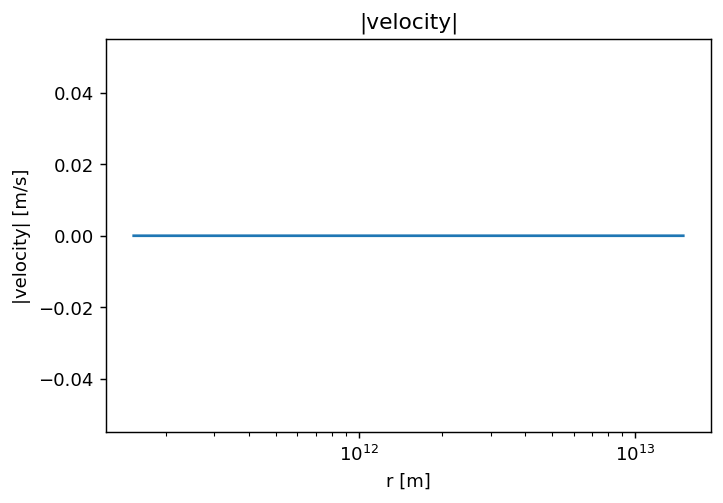

In [29]:
plt.figure(dpi=130)
plt.title('|velocity|')
plt.plot(rs, vs)
plt.xscale('log')
# plt.yscale('log')
plt.xlabel(r'r [m]')
plt.ylabel(r'|velocity| [m/s]')